# 1 - Data Loading 

In [1]:
import os, sys
codebase_root = os.path.dirname(os.path.abspath(''))
sys.path.append(codebase_root)

In [2]:
# Python 3.9 with: pandas, matplotlib, seaborn, sklearn.
import pandas as pd
import numpy as np
import tkinter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from typing import List
import xgboost

In [3]:
path = os.path.join(codebase_root, 'benchmarking/dataset/csvs/us_census.csv')
df = pd.read_csv(path, sep=",")
removed_columns = ['id', 'fnlwgt', 'sequence_pos']
for c in removed_columns:
    if c in df.columns:
        df = df.drop(c, axis=1)

In [4]:
df.head(3)

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K


In [5]:
print(f'Number of data rows: {len(df)} \nIs there any missing values ? {df.isnull().values.any()}')

Number of data rows: 48842 
Is there any missing values ? False


In [6]:
# Useful to get a complete data report
# from pandas_profiling import ProfileReport
# ProfileReport(df)

# 2 - Data Bias

In [7]:
target = 'income'
sensitive = 'sex'
male = 'Male'
female = 'Female'
target_high = '>50K'
target_low ='<=50K' 

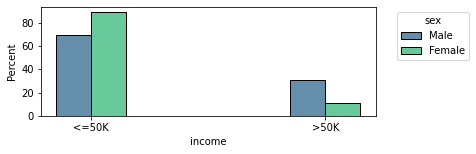

In [8]:
fig, ax = plt.subplots(figsize=(6, 2))
arguments = dict(data=df, x=target, hue=sensitive, kde=False, multiple="dodge", stat="percent", common_norm=False, discrete=True, shrink=.3, ax=ax, palette='viridis')
sns.histplot(**arguments)
ax.legend(handles=ax.legend_.legendHandles, labels=[t.get_text() for t in ax.legend_.texts],
          title=ax.legend_.get_title().get_text(),
          bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [9]:
df[[target, sensitive]].value_counts()

income  sex   
<=50K   Male      22732
        Female    14423
>50K    Male       9918
        Female     1769
dtype: int64

In [10]:
def calculate_statistical_parity(dff, target, sensitive):
    is_male = dff[sensitive] == male
    is_female = dff[sensitive] == female
    is_high = dff[target] == target_high
    is_low = dff[target] == target_low

    p_high_male = len(dff.loc[is_high & is_male]) / len(dff.loc[is_male])    
    p_high_female = len(dff.loc[is_high & is_female]) / len(dff.loc[is_female])
    spd =  abs(p_high_male - p_high_female)
    dic = {'p_high_male': p_high_male, 'p_high_female': p_high_female, 'spd': spd}
    results = {k: round(v, 2) for k, v in dic.items()}
    return results

# Can also do:
# df_pred.groupby('sex')['income'].value_counts(normalize=True)['Male']['>50K'] - df_pred.groupby('sex')['income'].value_counts(normalize=True)['Female']['>50K']

In [11]:
calculate_statistical_parity(df, target, sensitive)

{'p_high_male': 0.3, 'p_high_female': 0.11, 'spd': 0.19}

In the data, one can see the probability of having a high income as a male is 30% while it is 11% as a woman. 
<br />
The Statistical Disparity is 19%. Any percentage above 5% is considered high. 
<br />**We can confirm the data is biased against women.**

# 3 - Model Bias

In [12]:
def train_test_model(excluded_columns: List[str], target: str, calculate_disparity:bool = True):
    numeric_features = [c for c in ["age", "hours-per-week", "capital"] if c not in excluded_columns]
    categorical_features = [c for c in df.columns if c not in numeric_features + excluded_columns]
    assert len(numeric_features) + len(categorical_features) == len(df.columns) - len(excluded_columns)

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder()
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)])

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))]
    )

    x, y = df.drop(target, axis=1), df[target]
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=42)

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    acc = accuracy_score(y_pred, y_test)

    df_pred = x_test.copy()
    df_pred[target] = y_pred
    sd = calculate_statistical_parity(df_pred, target, sensitive)
    
    print('Checking: transformed array shape:', preprocessor.transform(x_train).shape)
    print(f'accuracy {round(acc * 100)}%')
    if calculate_disparity:
        print('statistical disparity:', sd)
        print('\n', df_pred[[target, sensitive]].value_counts())


In [13]:
train_test_model(excluded_columns=[target], target=target)

Checking: transformed array shape: (34189, 103)
accuracy 85%
statistical disparity: {'p_high_male': 0.25, 'p_high_female': 0.07, 'spd': 0.18}

 income  sex   
<=50K   Male      7257
        Female    4562
>50K    Male      2479
        Female     355
dtype: int64


In the model's prediction, one can see the probability of a man being predicted as high income is 30% while it is 11% for women. <br /> 
This shows how the model is biased against women and therefore simply **reflecting the bias present in the data**.

# 4 - Fairness Through Unawareness: removing the column

### Model bias without the column

In [14]:
train_test_model(excluded_columns=[target, sensitive], target=target)

Checking: transformed array shape: (34189, 101)
accuracy 85%
statistical disparity: {'p_high_male': 0.25, 'p_high_female': 0.08, 'spd': 0.18}

 income  sex   
<=50K   Male      7282
        Female    4548
>50K    Male      2454
        Female     369
dtype: int64


We removed the sensitive 'sex' column and ran the same experiment as above.
<br /> 
One can see the accuracy and the statistical disparity is still the same. 
<br /> This means removing the gender information has not hurt the prediction power of the model but **it also has not reduced the bias**. 
<br /> This is because the dataset still holds the gender information hidden inside other variables called **proxy variables**. 
<br /> This also prooves removing the sensitive column is near to **useless** to improve gender biases in model in production.

### Supervised guess on sensitive attribute

In [15]:
train_test_model(excluded_columns=[target, sensitive], target=sensitive, calculate_disparity=False)

Checking: transformed array shape: (34189, 101)
accuracy 84%


We are able to guess the gender of a data point with a very high accuracy and without the gender information itself. This prooves further how a data point has a **gender footprint** hidden inside its other features.

### Correlation matrix shows proxy variables

In [16]:
from fairlens.metrics import unified
correlation_matrix = unified.correlation_matrix(df).round(2)[[sensitive]]

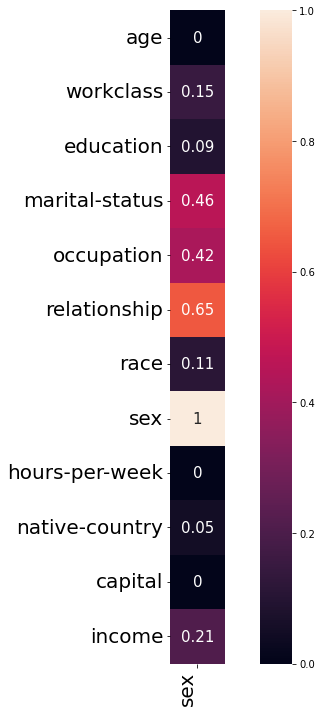

In [17]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax=sns.heatmap(correlation_matrix,
            vmin=0,
            vmax=1,
            annot=True,
            annot_kws={"size": 15},
            square=True,
            cbar=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right", fontdict={"fontsize": 20})
_ = ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment="right", fontdict={"fontsize": 20})

We might wonder what are the proxy variables. Checking for **correlations** between the sensitive attribute and the rest of the attributes answers this: **relationship**, **marital-status** and **occupation** are strong tells.

In [18]:
excluded_columns = [c for c in df.columns if c not in ['relationship', 'marital-status', 'occupation']]
train_test_model(excluded_columns=excluded_columns, target=sensitive, calculate_disparity=False)

Checking: transformed array shape: (34189, 28)
accuracy 83%


A confirmation of the above how we are able to get 83% accuracy in predicting someone's gender by using solely the relationship, marital-status and occupation variable.